In [1]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F
import lightning as L
from lightning.pytorch.loggers import WandbLogger
from scipy import stats

# log into to wandb to log results
import wandb
wandb.login()

datadir = '../out/corrected/counts'
procdir = '../out/modelling/processed'
BATCH_SIZE=64

os.makedirs(procdir, exist_ok=True)
np.random.seed(12345)
rerun_encoding = False


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: szsctt. Use `wandb login --relogin` to force relogin


## Data import
Load the r0 and r1 datasets.

In [2]:
# get files to be imported
files = glob.glob(os.path.join(datadir, 'r[0-1]_np-cc*aa-seq-counts.tsv.gz'))
files

['../out/corrected/counts/r1_np-cc_gel-extract_aa-seq-counts.tsv.gz',
 '../out/corrected/counts/r0_np-cc_repeat_aa-seq-counts.tsv.gz',
 '../out/corrected/counts/r0_np-cc_gel-extract_aa-seq-counts.tsv.gz',
 '../out/corrected/counts/r1_np-cc_aa-seq-counts.tsv.gz',
 '../out/corrected/counts/r0_np-cc_aa-seq-counts.tsv.gz']

In [3]:
# read tsv files
df = pd.concat([pd.read_csv(f, sep='\t').assign(round = os.path.basename(f)[:2]) for f in files], axis=0)

# sum counts within each round
df = df.groupby(['round', 'sequence']).sum().reset_index()

df

,round,sequence,count
0,r0,MAADGYLPDWLEDNLSEGIREWWAFKPGAPKPKANQQKQDDGRGLV...,1
1,r0,MAADGYLPDWLEDNLSEGIREWWAFKPGAPKPKANQQKQDDGRGLV...,1
2,r0,MAADGYLPDWLEDNLSEGIREWWAFKPGAPQPKANQQHQDNARGLV...,1
3,r0,MAADGYLPDWLEDNLSEGIREWWAFKPGAPQPKANQQHQDNARGLV...,1
4,r0,MAADGYLPDWLEDNLSEGIREWWAFKPGAPQPKANQQHQDNARGLV...,1
...,...,...,...
1196904,r1,MAADGYLPDWLEDTLSEGIRQWWKLKPGVPQPKANQQKQDDGRGLV...,1
1196905,r1,MAADGYLPDWLEDTLSEGIRQWWKLKPGVPQPKANQQKQDDGRGLV...,1
1196906,r1,MAADGYLPDWLEDTLSEGIRQWWKLKPGVPQPKANQQKQDNRRGLV...,1
1196907,r1,MAADGYLPDWLEDTLSEGIRQWWKLKPGVPQPKPAERHKDDSRGLV...,1


Count the number of unique sequences and total count in each round.

In [4]:
print("Number of unique sequences in each round:")
df.groupby('round').size()

Number of unique sequences in each round:


round
r0    772738
r1    424171
dtype: int64

In [5]:
print("Total count for each round:")
total = (df
         .drop('sequence', axis=1)
         .groupby('round')
         .sum()
         )
total

Total count for each round:


,count
round,
r0,911631
r1,613756


We have a higher total count for r0 compared to r1.  We will need to take this into account during modelling by weighting the loss function.

Plotting the CDF of counts for the two libraries

<Axes: xlabel='count', ylabel='Proportion'>

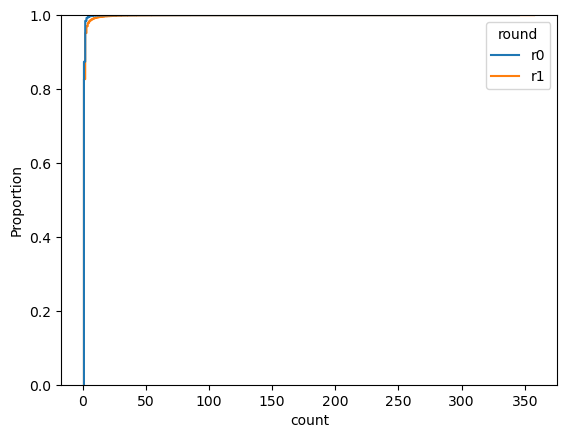

In [6]:
sns.ecdfplot(data=df, x='count', hue='round')

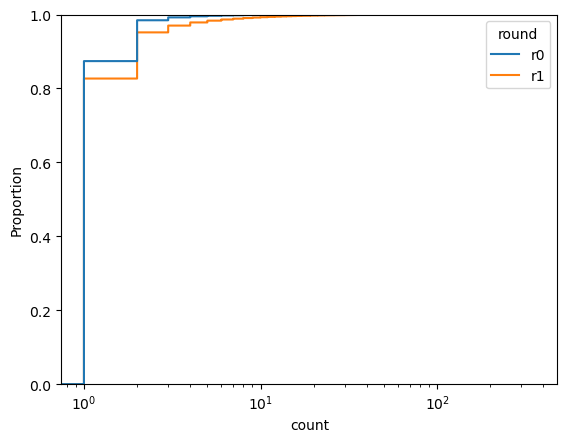

In [7]:

sns.ecdfplot(data=df, x='count', hue='round', )
plt.xscale('log')

## Train/test/eval sets
We will need to remove a dataset for evaluation - I remove 20% of the unique sequences for evaluation of different kinds of models and 10% for a final testing set.  Most sequecnes have low counts, so we try to get some with high counts in each set. 

For this, we caculate a set of weights according to the model-based enrichment paper, and then include some observations with high and low weights.  The weights are caculated as follows:

$$w_i = \frac{1}{(2\sigma_i^2)}$$

where:

$$\sigma_i^2 = \frac{1}{n_i^{r_1}}(1-\frac{n_i^{r_1}}{\sum_i n^{r_1}_i}) + \frac{1}{n_i^{r_0}}(1-\frac{n_i^{r_0}}{\sum_i n^{r_0}_i})$$

Where $n_i^{r_0}$ is the count for the $i^{th}$ sequence in the round 0 library, and $n_i^{r_1}$ is the count for the $i^{th}$ sequence in the round 1 library.  This value is high if the counts in both libraries are high, and low if the counts in both libraries are low.  First calculating this for each sequence, and plotting the distribution.

We also need to add a pseudo-count of 1 to all observations for this quantitity to be defined.

In [8]:
pseduo = 1
df_unique = (df
             # add pseudocunt
             .assign(count = lambda x: x['count'] + pseduo)
             # r0 and 1 counts in separate columns
             .pivot(index='sequence', columns='round', values='count')
             .fillna(pseduo)
             .reset_index()
             # calculate log enrichment and weights as per MBE paper
             .assign(
                le = lambda x: np.log2((x['r1']/x['r1'].sum())/(x['r0']/x['r0'].sum())),
                sig = lambda x: 1/x['r1']*(1-x['r1']/(x['r1'].sum())) + 1/x['r0']*(1-x['r0']/(x['r0'].sum())),
                weight = lambda x: 1/(2*x['sig']),
                     )
             )
df_unique

round,sequence,r0,r1,le,sig,weight
0,MAADGYLPDWLEDNLSEGIREWWAFKPGAPKPKANQQKQDDGRGLV...,2.0,1.0,-0.777280,1.499999,0.333334
1,MAADGYLPDWLEDNLSEGIREWWAFKPGAPKPKANQQKQDDGRGLV...,2.0,1.0,-0.777280,1.499999,0.333334
2,MAADGYLPDWLEDNLSEGIREWWAFKPGAPKPKANQQKQDDGRGLV...,1.0,2.0,1.222720,1.499999,0.333334
3,MAADGYLPDWLEDNLSEGIREWWAFKPGAPQPKANQQHQDNARGLV...,2.0,1.0,-0.777280,1.499999,0.333334
4,MAADGYLPDWLEDNLSEGIREWWAFKPGAPQPKANQQHQDNARGLV...,2.0,1.0,-0.777280,1.499999,0.333334
...,...,...,...,...,...,...
1170654,MAADGYLPDWLEDTLSEGIRQWWKLKPGVPQPKPAERHKDDSRGLV...,3.0,1.0,-1.362243,1.333332,0.375000
1170655,MAADGYLPDWLEDTLSEGIRQWWKLKPGVPQPKPAERHKDDSRGLV...,3.0,1.0,-1.362243,1.333332,0.375000
1170656,MAADGYLPDWLEDTLSEGIRQWWKLKPGVPQPKPAERHKDDSRGLV...,2.0,1.0,-0.777280,1.499999,0.333334
1170657,MAADGYLPDWLEDTLSEGIRQWWKLKPGVPQPKPAERHKDDSRGLV...,1.0,2.0,1.222720,1.499999,0.333334


<Axes: xlabel='sig', ylabel='Proportion'>

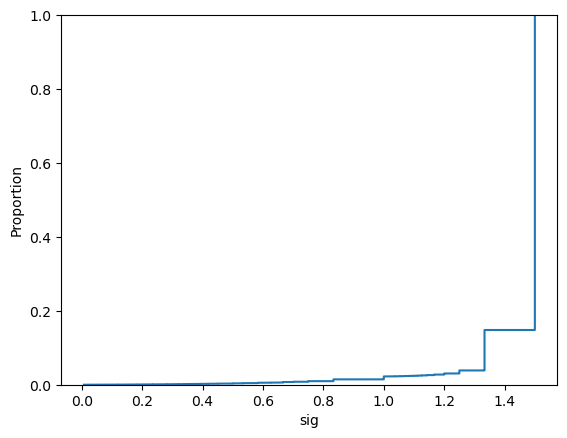

In [9]:
sns.ecdfplot(data = df_unique, x = "sig")

<Axes: xlabel='weight', ylabel='Proportion'>

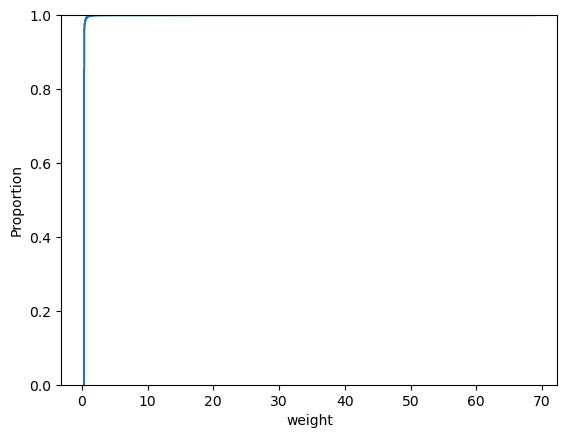

In [10]:
sns.ecdfplot(data=df_unique, x='weight')

Computing quantiles for the numeric columns will give us an idea of where might be a good threshold for high and low counts.

In [11]:
df_unique.quantile(np.arange(0, 1, 0.05), numeric_only=True)

round,r0,r1,le,sig,weight
0.00,1.0,1.0,-6.696143,0.007257,0.333334
0.05,1.0,1.0,-1.362243,1.333332,0.333334
0.10,1.0,1.0,-0.777280,1.333332,0.333334
0.15,1.0,1.0,-0.777280,1.499999,0.333334
0.20,1.0,1.0,-0.777280,1.499999,0.333334
0.25,1.0,1.0,-0.777280,1.499999,0.333334
0.30,1.0,1.0,-0.777280,1.499999,0.333334
0.35,2.0,1.0,-0.777280,1.499999,0.333334
0.40,2.0,1.0,-0.777280,1.499999,0.333334
0.45,2.0,1.0,-0.777280,1.499999,0.333334


These weights have a very skewed distribution (as do the counts) - this might be an issue for modelling, since only a few high-count sequences will dominate the results. 

It would be good to try to keep the test and eval sets roughly balanced, with sequences with high and low weights. For this, we will take equal numbers of sequences from the top 10% and the bottom 90%.  We will need to keep these sets small, since otherwise we'll be removing most of the training data. I'll define 'high-confidence' sequences those weights equal to or higher than 1, and 'low-confidence' sequences those with weights lower than 1.  I'll take 50 sequences from each set for each of the eval and test sets.

First, checking how many 'high-confidence' and 'low-confidence' sequences we have with this threshold:

In [12]:
thresh = 1
df_unique = df_unique.assign(set = lambda x: ['high' if w >= thresh else 'low' for w in x['weight']])
df_unique.value_counts('set')

set
low     1166424
high       4235
Name: count, dtype: int64

In [13]:
df_test_eval = df_unique.sample(frac=1).groupby('set').head(100)
df_test = df_test_eval.groupby('set').head(50)

# remove test set from evaluation set
df_eval = df_test_eval[~df_test_eval['sequence'].isin(df_test['sequence'])]
df_train = df_unique[~df_unique['sequence'].isin(df_test_eval['sequence'])]

# check we have 50 sequences in each set, and remainder in training set
df_eval.value_counts('set'), df_test.value_counts('set'), df_train.value_counts('set')

(set
 high    50
 low     50
 Name: count, dtype: int64,
 set
 high    50
 low     50
 Name: count, dtype: int64,
 set
 low     1166324
 high       4135
 Name: count, dtype: int64)

## Encoding sequences

In this case I one-hot encode the data.  It's more effecient to encode the unique sequences rather than the full training set for model-based enrichment, so I'll do this now and save the results.

In [14]:
aas = [i for i in 'ACDEFGHIKLMNPQRSTVWY*']
def one_hot(seq, max_l):
    """
    One hot encode a sequence of amino acids
    """
    out = np.zeros((max_l, len(aas)))
    for i in range(max_l):
        if i < len(seq):
            out[i, aas.index(seq[i])] = 1
    return out.flatten()

one_hot('ACD', 5)


array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [15]:
# encode datasets
def encode(df, max_seq_length):
    df = (df
          .assign(encoded = df['sequence'].apply(lambda x: one_hot(x, max_seq_length)))
          .drop('sequence', axis=1)
          )
    return df

if not os.path.exists(os.path.join(procdir, 'train_onehot.pkl')) or rerun_encoding:
    max_seq_length = df_unique['sequence'].str.len().max() + 10
    df_train = encode(df_train, max_seq_length)
    df_eval = encode(df_eval, max_seq_length)
    df_test = encode(df_test, max_seq_length)
    
    # save data
    df_train.to_pickle(os.path.join(procdir, 'train_onehot.pkl'))
    df_eval.to_pickle(os.path.join(procdir, 'eval_onehot.pkl'))
    df_test.to_pickle(os.path.join(procdir, 'test_onehot.pkl'))

else:
    #df_train = pd.read_pickle(os.path.join(procdir, 'train.pkl')) # too large
    df_eval = pd.read_pickle(os.path.join(procdir, 'eval_onehot.pkl'))
    df_test = pd.read_pickle(os.path.join(procdir, 'test_onehot.pkl'))

## Model-based enrichment dataset

For model based enrichment, we create a dataset where we sample sequences the number of times they were seen in each selection round.  For each sample, the sequence is labelled according to which round it appeared in: -1 for r0 and +1 for r1.  For example, if we have a sequence that was seen once in r0 and twice in r1, it would appear in the final dataset once with a label of -1 and twice with a label of +1.

The evaluation set would look like this:

In [16]:
# add labels to data based on if the sequence base observed in the r0 and r1 libraries
df_example = (df_eval
                .loc[:, ['encoded', 'r0', 'r1']]
                .melt(id_vars = 'encoded', value_vars = ['r0', 'r1'], var_name = 'round', value_name = 'count')
                .assign(label = lambda x: (x['round'] == 'r1').astype(int))
                )

# sample sequences according to their count
df_example = df_example.reindex(df_example.index.repeat(df_example['count']))

df_example

,encoded,round,count,label
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",r0,2.0,0
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",r0,2.0,0
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",r0,1.0,0
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",r0,2.0,0
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",r0,2.0,0
...,...,...,...,...
199,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",r1,20.0,1
199,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",r1,20.0,1
199,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",r1,20.0,1
199,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",r1,20.0,1


## Dataloader

Creating a dataset and dataloader class for these datasets.  I wrap some of the code from earlier in a lightning data module class.

In [17]:
class MBEDataset(Dataset):

    def __init__(self, df):
        self.df_raw = df
        self.df = self.create_mbe_dataset(df)
    
    def create_mbe_dataset(self, df):

        df = (df
              .loc[:, ['encoded', 'r0', 'r1']]
              .melt(id_vars=['encoded'], value_vars=['r0', 'r1'], var_name='round', value_name='value')
              .assign(label = lambda x: (x['round'] == 'r1').astype(int))
        )
        df = df.reindex(df.index.repeat(df['value'])).reset_index()

        return df

    def get_weights(self):
        """
        Number of examples in each class
        """
        counts = (self.df
                .groupby('label')
                .size()
               )
        return torch.tensor(counts.loc[1] / counts.loc[0], dtype=torch.float64)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        return row['encoded'], float(row['label'])

class LEDataset(Dataset):
    """
    Log enrichment dataset
    """

    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):

        row = self.df.iloc[idx]
        return row['encoded'], row['le']

class MBEDataModule(L.LightningDataModule):

    def __init__(self, data_dir, batch_size = 32):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

    def setup(self, enc="onehot", stage=None):
        self.train = pd.read_pickle(os.path.join(self.data_dir, f'train_{enc}.pkl'))
        self.eval = pd.read_pickle(os.path.join(self.data_dir, f'eval_{enc}.pkl'))
        self.test = pd.read_pickle(os.path.join(self.data_dir, f'test_{enc}.pkl'))

    def train_dataloader(self):
        return DataLoader(MBEDataset(self.train), batch_size=self.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(LEDataset(self.eval), batch_size=self.batch_size)
    
    def test_dataloader(self):
        return DataLoader(LEDataset(self.test), batch_size=self.batch_size)
    
# test out dataset class
ds = MBEDataset(df_eval)
ds[0]



(array([0., 0., 0., ..., 0., 0., 0.]), 0.0)

In [18]:
ds.get_weights()

tensor(1.2274, dtype=torch.float64)

In [19]:
le = LEDataset(df_eval)
le[0]

(array([0., 0., 0., ..., 0., 0., 0.]), -0.7772801743351354)

In [20]:
# test out datamodule class - takes a while to load pickled data
dm = MBEDataModule(procdir, batch_size=BATCH_SIZE)
dm.setup()
test = next(iter(dm.train_dataloader()))
test

[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64),
 tensor([1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1.,
         0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1.,
         0., 1., 1., 1., 1., 0., 0., 1., 0., 0.], dtype=torch.float64)]

## Model

In this case, we'll use a simple feedforward network with two layers.

In [31]:
class MBELogisticRegression(nn.Module):
    """
    Class for logistic regression. 
    Returns logits by default, or probabilities if probs=True.
    """

    def __init__(self, input_size, pos_weight=None):
        super().__init__()
        self.linear = nn.Linear(input_size, 1, dtype = torch.float64)
        self.pos_weight = 1 if pos_weight is None else pos_weight

    def forward(self, x, probs=False):
        """
        Return logits or probabilities
        
        """

        logits = self.linear(x)
        if probs:
            return torch.sigmoid(logits)
        else:
            return logits

    def predict(self, x):
        """
        Return density ratio, an estimate of log enrichment
        """
        
        # get probability for positive class
        p = self.forward(x, probs=True)

        # density ratio is p/(1-p), adjusted for class imbalance
        return p/(1-p) / self.pos_weight

class MBEFeedForward(MBELogisticRegression):

    def __init__(self, input_size, pos_weight=None, n_units=128):
        super().__init__(input_size, pos_weight)
        self.n_units = n_units
        self.pos_weight = pos_weight
        self.linear = nn.Sequential(
            nn.Linear(input_size, n_units, dtype = torch.float64),
            nn.ReLU(),
            nn.Linear(n_units, 1, dtype = torch.float64),
        )


model = MBEFeedForward(len(ds[0][0]), pos_weight=ds.get_weights())
model(test[0])[:5]

tensor([[0.0215],
        [0.0082],
        [0.0159],
        [0.0398],
        [0.0400]], dtype=torch.float64, grad_fn=<SliceBackward0>)

In [32]:
model.predict(test[0])[:5]

tensor([[0.8324],
        [0.8215],
        [0.8278],
        [0.8478],
        [0.8480]], dtype=torch.float64, grad_fn=<SliceBackward0>)

Use a weighted BCE loss function with the Adam optimizer.  The classes are weighted using the ratio of total reads in r1 vs r0.

In [33]:
class LitMBE(L.LightningModule):

    def __init__(self, model, lr=0.001, pos_weight = 1):
        super().__init__()
        self.model = model
        self.loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        self.spearman = stats.spearmanr 
        self.lr = lr
        self.save_hyperparameters()

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.model(x).squeeze()
        loss = self.loss(logits, y)
        self.log('train_loss', loss, on_step = True, on_epoch = True, prog_bar = True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        with torch.no_grad():
            le = self.model.predict(x).squeeze().cpu().numpy()
            spearman = self.spearman(le, y.cpu().numpy()).statistic
            self.log('val_spearman', spearman, on_step = False, on_epoch = True, prog_bar = True)
        

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [36]:
# instantiate lightning model
lit_model = LitMBE(model, pos_weight=ds.get_weights())

# use weights and biases logger
wandb_logger = WandbLogger(project='mbe', name = "feedforward")
wandb_logger.experiment.config.update({
    "lr": 0.001,
    "pos_weight": ds.get_weights(),
    "n_units": 128,
    "batch_size": BATCH_SIZE,
    "max_seq_length": max_seq_length,
    "arch": "feedforward",
    "enc": "onehot"
})

# train model
trainer = L.Trainer(max_epochs=10, logger = wandb_logger)
trainer.validate(model = lit_model, datamodule = dm)
trainer.fit(model = lit_model, datamodule = dm)
wandb.finish()

/data/home/sscott@cmri.com.au/micromamba/envs/torch2/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params
--------------------------------------------
0 | model | MBEFeedForward    | 2.0 M 
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.065     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/data/home/sscott@cmri.com.au/micromamba/envs/torch2/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.
/data/home/sscott@cmri.com.au/micromamba/envs/torch2/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▃▂▂▁▁▁▁▁▁
train_loss_step,▄▆▅▅▄▆▂▅▆▃▆▃▆▅▄▃▄▅█▅▇▁▃▅▆▂▆▄▅▃▅▆▄▇▅▅▆▅▄▃
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_spearman,▆▃▅▂▃▂▇▆▁█
epoch,9
train_loss_epoch,0.75758
train_loss_step,0.75566
trainer/global_step,603829
val_spearman,0.35388


Future improvements / things to try:

 - Weight decay / regularization
 - Different architechtures
 - Different encoding (label encoding / embeddings from ESM-2)
 - Weight decay / regularization